In [1]:
import pandas as pd
import numpy as np
from os import environ
from citrination_client import *
from citrination_client.views.data_view_builder import DataViewBuilder

client = CitrinationClient(environ['CITRINATION_API_KEY'], 'https://citrination.com')

In [2]:
out = 'PROPERTY: HV'

outs = ['PROPERTY: Exp. Density (g/cm$^3$)',
       'PROPERTY: Calculated Density (g/cm$^3$)', 'PROPERTY: HV',
       'PROPERTY: YS (MPa)', 'PROPERTY: UTS (MPa)', 'PROPERTY: Elongation (%)',
       'PROPERTY: Elongation plastic (%)',
       'PROPERTY: Exp. Young modulus (GPa)',
       'PROPERTY: Calculated Young modulus (GPa)']

In [7]:
# build DV
def build_dv(out):
    # MPEA post-processed
    ds_id = '190954'

    # Create ML configuration
    dv_builder = DataViewBuilder()
    dv_builder.dataset_ids([ds_id])

    # Define descriptors
    desc_formula = InorganicDescriptor(key='formula', threshold=1.0) # threshold <= 1.0; default in future releases
    dv_builder.add_descriptor(descriptor=desc_formula, role='input', group_by_key=True)

    desc_temp = RealDescriptor(key='Property Test temperature', lower_bound=-10000, upper_bound=10000, units='$^\circ$C')
    dv_builder.add_descriptor(descriptor=desc_temp, role='input')

    desc_test = CategoricalDescriptor(key='Property Type of test', categories=['C', 'T'])
    dv_builder.add_descriptor(descriptor=desc_test, role='input')

    desc_synth = CategoricalDescriptor(key='Property Processing method', categories=['CAST', 'ANNEAL', 'POWDER', 'WROUGHT', 'OTHER'])
    dv_builder.add_descriptor(descriptor=desc_synth, role='input'),

    updated_key = out.split('(')[0].strip().replace('PROPERTY:', 'Property')
    
    if out == 'PROPERTY: UTS (MPa)':
        updated_key = 'Property Ultimate tensile strength'
    
    desc_gen = RealDescriptor(key=updated_key, lower_bound=-100000, upper_bound=100000, units='')
    dv_builder.add_descriptor(descriptor=desc_gen, role='output')

    dv_config = dv_builder.build()

    # Create a data view using the above configuration and store the ID
    dv_name = 'MPEA_dataset_{}'.format(out)
    dv_desc = 'genearated from ipynb'
    dv_id = client.data_views.create(configuration=dv_config, name=dv_name, description=dv_desc)
    print('Data view {} was successfully created.'.format(dv_id))

In [24]:
# # update with new config
# client.data_views.update(id=dv_id, configuration=dv_config, name=dv_name, description=dv_desc)

In [30]:
def predict(df_candidates, out, updated_key, dv_id):
    props = [out]
    candidates = [{'formula': row['FORMULA'], 
                   'Property Processing method': row['PROPERTY: Processing method'], 
                   'Property Type of test':row['PROPERTY: Type of test'], 'Property Test temperature':row['PROPERTY: Test temperature ($^\circ$C)']} for index, row in df_candidates.iterrows()]


    n = 10000
    batches = [candidates[i:i + n] for i in range(0, len(candidates), n)]

    resp = []
    print(dv_id)
    for batch in batches:
        print('Batch length: ', len(batch))
        resp.extend(client.models.predict(dv_id, batch))
        
    df_candidates['Predicted {}'.format(updated_key)] = [round(r.get_value(updated_key).value, 1) for r in resp]
    df_candidates['Predicted {} loss'.format(updated_key)] = [round(r.get_value(updated_key).loss, 1) for r in resp]
    return df_candidates


In [32]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "simple_white"

def plot(df, out, updated_key):
    print(df.keys())
    df = df.sort_values('Predicted {} loss'.format(updated_key), ascending=False)
    columns = ['FORMULA', out, 'Predicted {}'.format(updated_key), 'Predicted {} loss'.format(updated_key), "REFERENCE: doi"]
    df[columns].to_csv('outliers/{}.csv'.format(updated_key))

    fig = make_subplots(rows=1, cols=3, subplot_titles=[out+" ({})".format(len(df)), out, out], 
                        specs=[[{"type": "scatter"}, {"type": "scatter"}, {"type": "table"}]], 
                       column_widths=[0.8,0.8,1.2]
                       )
    
    fig.add_trace(go.Histogram(x=df[out], nbinsx=30),row=1, col=1)
    fig.add_trace(go.Scatter(x=df[out], y=df['Predicted {}'.format(updated_key)], error_y=dict(array=df['Predicted {} loss'.format(updated_key)]), hovertext=df['FORMULA'], mode='markers'), row=1, col=2)

    fig.update_layout(font=dict(family="Barlow Semi Condensed", size=24), width=2000, height=800, showlegend=False)

    print("headers: ", out, out+'_pred', out+'_pred_loss',)
    table = go.Table(header=dict(values=['FORMULA', out, out+'_pred', out+'_pred_loss', 'DOI'], font=dict(size=16)), columnwidth=[160, 60, 60, 60, 160],
                     cells=dict(values=[df['FORMULA'], df[out], df['Predicted {}'.format(updated_key)], df['Predicted {} loss'.format(updated_key)], df["REFERENCE: doi"]], font=dict(size=16)))


    fig.add_trace(table, row=1, col=3)
    fig.update_xaxes(title_text=out, row=1, col=1)
    fig.update_yaxes(title_text='Counts', row=1, col=1)
    
    fig.update_xaxes(title_text='actual', row=1, col=2)
    fig.update_yaxes(title_text='predicted', row=1, col=2)


    fig.show()
    
    return None


In [12]:
for out in outs:
    build_dv(out)

Data view 16230 was successfully created.
Data view 16231 was successfully created.
Data view 16232 was successfully created.
Data view 16233 was successfully created.
Data view 16234 was successfully created.
Data view 16235 was successfully created.
Data view 16236 was successfully created.
Data view 16237 was successfully created.
Data view 16238 was successfully created.


16269
Batch length:  1118
Index(['IDENTIFIER: Reference ID', 'FORMULA', 'PROPERTY: Microstructure',
       'PROPERTY: Processing method', 'PROPERTY: BCC/FCC/other',
       'PROPERTY: grain size ($\mu$m)', 'PROPERTY: Exp. Density (g/cm$^3$)',
       'PROPERTY: Calculated Density (g/cm$^3$)', 'PROPERTY: HV',
       'PROPERTY: Type of test', 'PROPERTY: Test temperature ($^\circ$C)',
       'PROPERTY: YS (MPa)', 'PROPERTY: UTS (MPa)', 'PROPERTY: Elongation (%)',
       'PROPERTY: Elongation plastic (%)',
       'PROPERTY: Exp. Young modulus (GPa)',
       'PROPERTY: Calculated Young modulus (GPa)',
       'PROPERTY: O content (wppm)', 'PROPERTY: N content (wppm)',
       'PROPERTY: C content (wppm)', 'REFERENCE: doi', 'REFERENCE: year',
       'REFERENCE: title', 'Predicted Property Ultimate tensile strength',
       'Predicted Property Ultimate tensile strength loss'],
      dtype='object')
headers:  PROPERTY: UTS (MPa) PROPERTY: UTS (MPa)_pred PROPERTY: UTS (MPa)_pred_loss


/Users/chrisborg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/chrisborg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



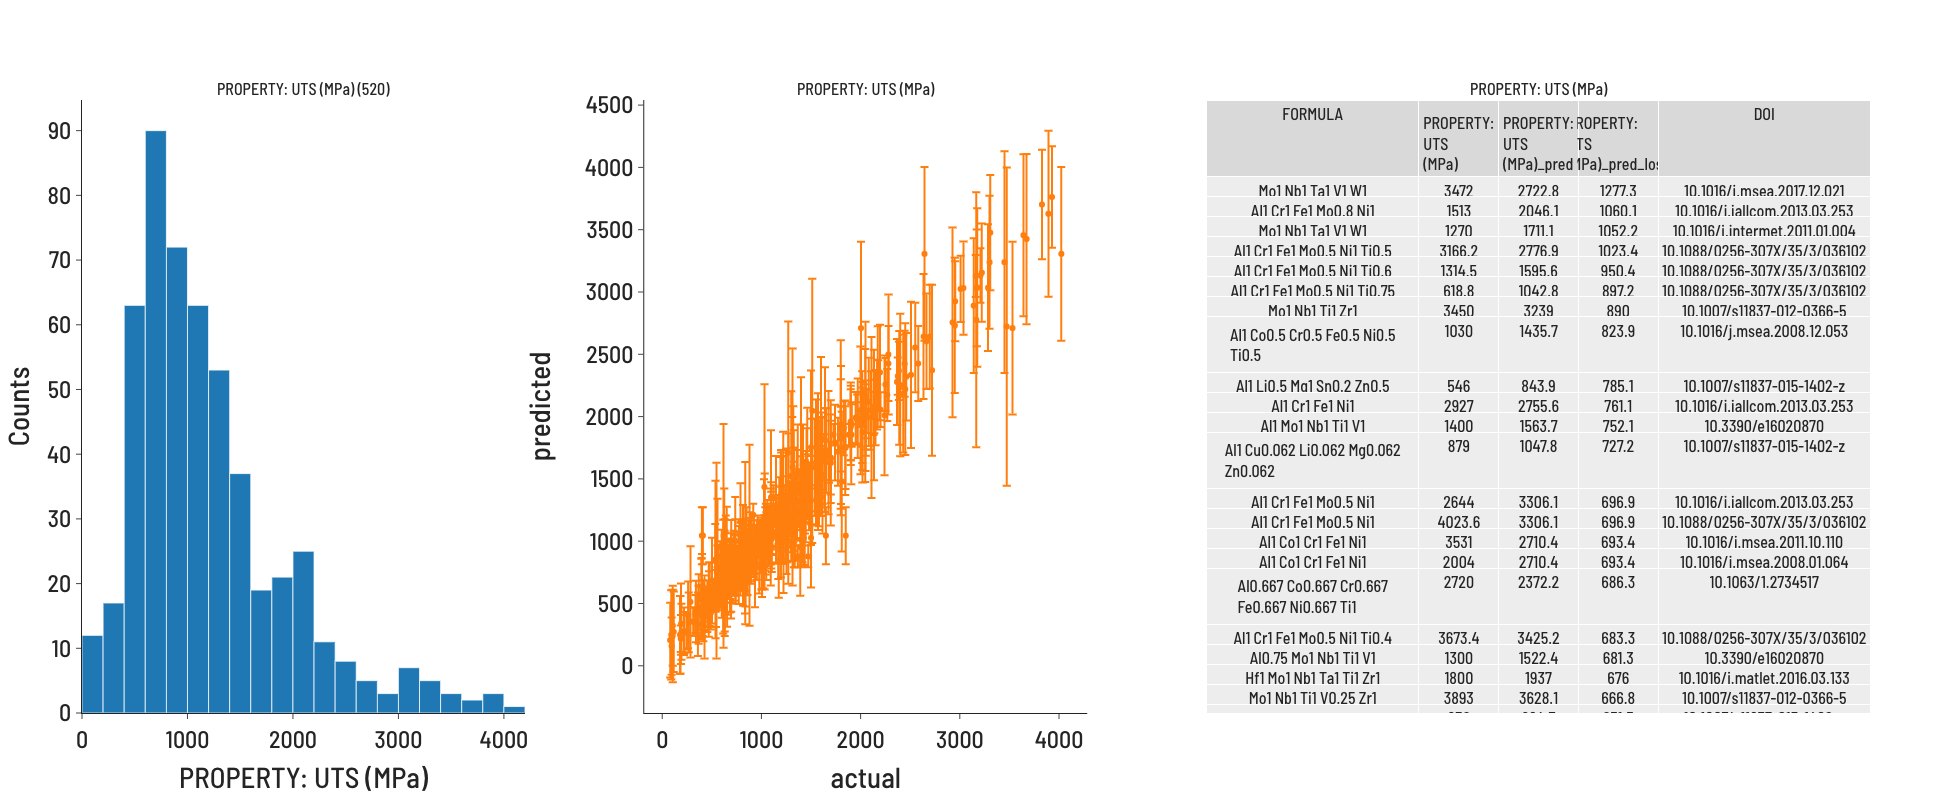

In [40]:
input_df = pd.read_csv('../../MPEA_dataset.csv')
features = ['FORMULA', 'PROPERTY: Processing method', 'PROPERTY: Type of test', 'PROPERTY: Test temperature ($^\circ$C)']
df_candidates = input_df.dropna(subset=features)

out = 'PROPERTY: UTS (MPa)'
updated_key = 'Property Ultimate tensile strength'        
df_candidates = predict(df_candidates, out, updated_key, 16269)
plot(df_candidates.dropna(subset=[out]), out, updated_key)

16230 PROPERTY: Exp. Density (g/cm$^3$)
16230
Batch length:  1118
Index(['IDENTIFIER: Reference ID', 'FORMULA', 'PROPERTY: Microstructure',
       'PROPERTY: Processing method', 'PROPERTY: BCC/FCC/other',
       'PROPERTY: grain size ($\mu$m)', 'PROPERTY: Exp. Density (g/cm$^3$)',
       'PROPERTY: Calculated Density (g/cm$^3$)', 'PROPERTY: HV',
       'PROPERTY: Type of test', 'PROPERTY: Test temperature ($^\circ$C)',
       'PROPERTY: YS (MPa)', 'PROPERTY: UTS (MPa)', 'PROPERTY: Elongation (%)',
       'PROPERTY: Elongation plastic (%)',
       'PROPERTY: Exp. Young modulus (GPa)',
       'PROPERTY: Calculated Young modulus (GPa)',
       'PROPERTY: O content (wppm)', 'PROPERTY: N content (wppm)',
       'PROPERTY: C content (wppm)', 'REFERENCE: doi', 'REFERENCE: year',
       'REFERENCE: title', 'Predicted Property Exp. Density',
       'Predicted Property Exp. Density loss'],
      dtype='object')
headers:  PROPERTY: Exp. Density (g/cm$^3$) PROPERTY: Exp. Density (g/cm$^3$)_pred PR

/Users/chrisborg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/chrisborg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



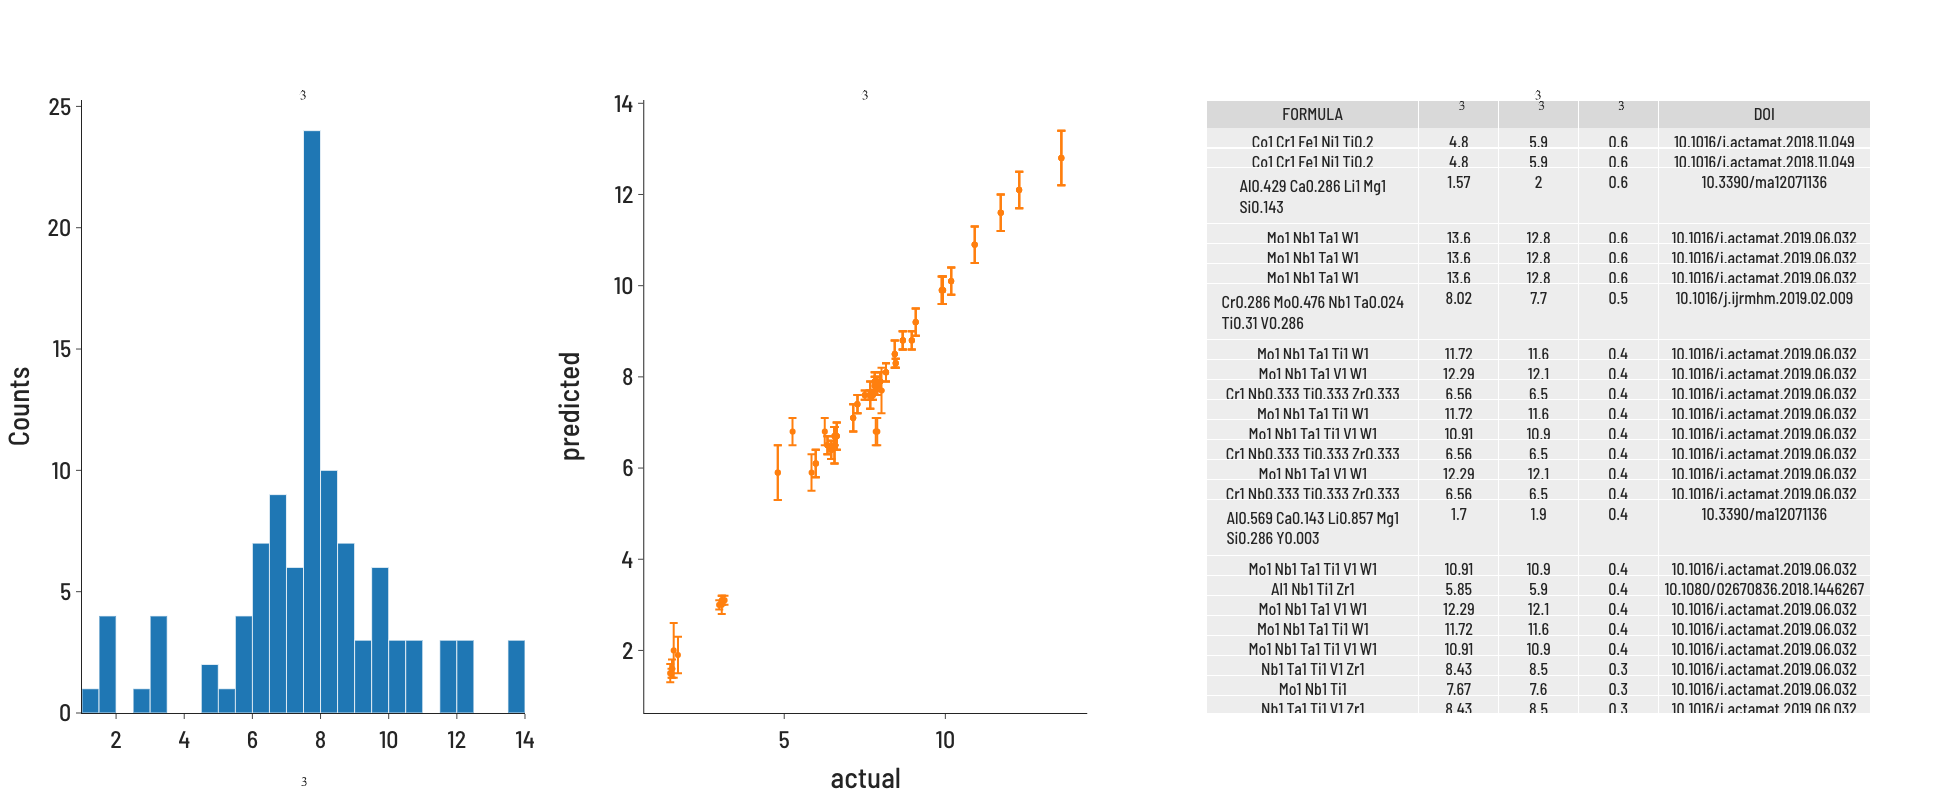

16231 PROPERTY: Calculated Density (g/cm$^3$)
16231
Batch length:  1118
Index(['IDENTIFIER: Reference ID', 'FORMULA', 'PROPERTY: Microstructure',
       'PROPERTY: Processing method', 'PROPERTY: BCC/FCC/other',
       'PROPERTY: grain size ($\mu$m)', 'PROPERTY: Exp. Density (g/cm$^3$)',
       'PROPERTY: Calculated Density (g/cm$^3$)', 'PROPERTY: HV',
       'PROPERTY: Type of test', 'PROPERTY: Test temperature ($^\circ$C)',
       'PROPERTY: YS (MPa)', 'PROPERTY: UTS (MPa)', 'PROPERTY: Elongation (%)',
       'PROPERTY: Elongation plastic (%)',
       'PROPERTY: Exp. Young modulus (GPa)',
       'PROPERTY: Calculated Young modulus (GPa)',
       'PROPERTY: O content (wppm)', 'PROPERTY: N content (wppm)',
       'PROPERTY: C content (wppm)', 'REFERENCE: doi', 'REFERENCE: year',
       'REFERENCE: title', 'Predicted Property Calculated Density',
       'Predicted Property Calculated Density loss'],
      dtype='object')
headers:  PROPERTY: Calculated Density (g/cm$^3$) PROPERTY: Calcula

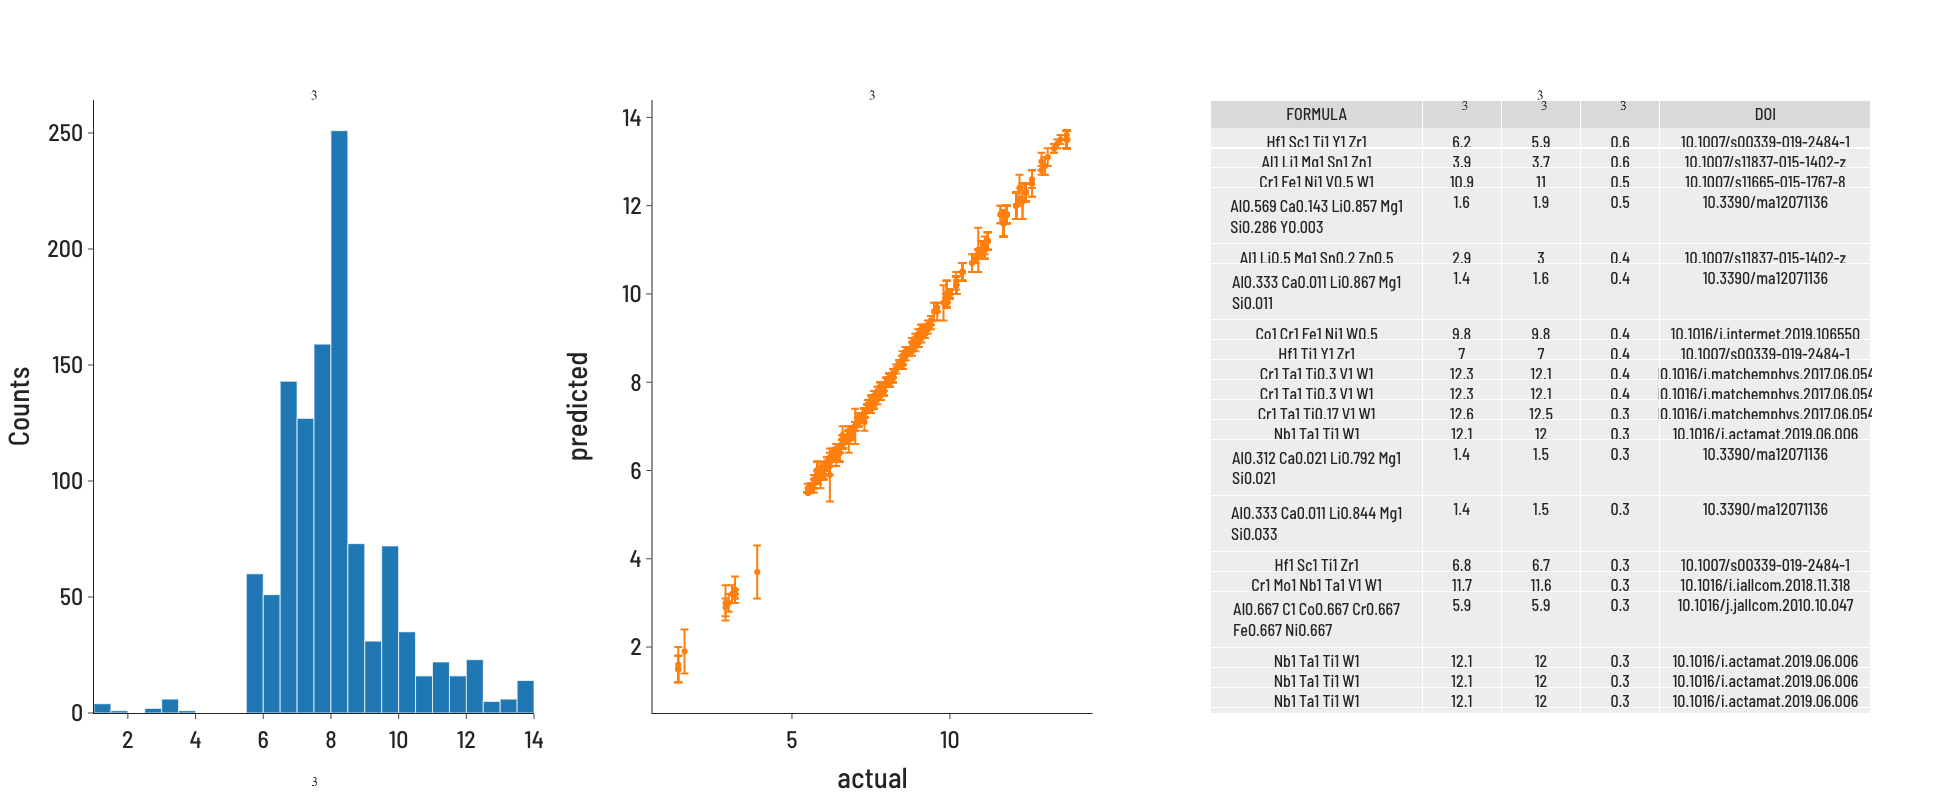

16232 PROPERTY: HV
16232
Batch length:  1118
Index(['IDENTIFIER: Reference ID', 'FORMULA', 'PROPERTY: Microstructure',
       'PROPERTY: Processing method', 'PROPERTY: BCC/FCC/other',
       'PROPERTY: grain size ($\mu$m)', 'PROPERTY: Exp. Density (g/cm$^3$)',
       'PROPERTY: Calculated Density (g/cm$^3$)', 'PROPERTY: HV',
       'PROPERTY: Type of test', 'PROPERTY: Test temperature ($^\circ$C)',
       'PROPERTY: YS (MPa)', 'PROPERTY: UTS (MPa)', 'PROPERTY: Elongation (%)',
       'PROPERTY: Elongation plastic (%)',
       'PROPERTY: Exp. Young modulus (GPa)',
       'PROPERTY: Calculated Young modulus (GPa)',
       'PROPERTY: O content (wppm)', 'PROPERTY: N content (wppm)',
       'PROPERTY: C content (wppm)', 'REFERENCE: doi', 'REFERENCE: year',
       'REFERENCE: title', 'Predicted Property HV',
       'Predicted Property HV loss'],
      dtype='object')
headers:  PROPERTY: HV PROPERTY: HV_pred PROPERTY: HV_pred_loss


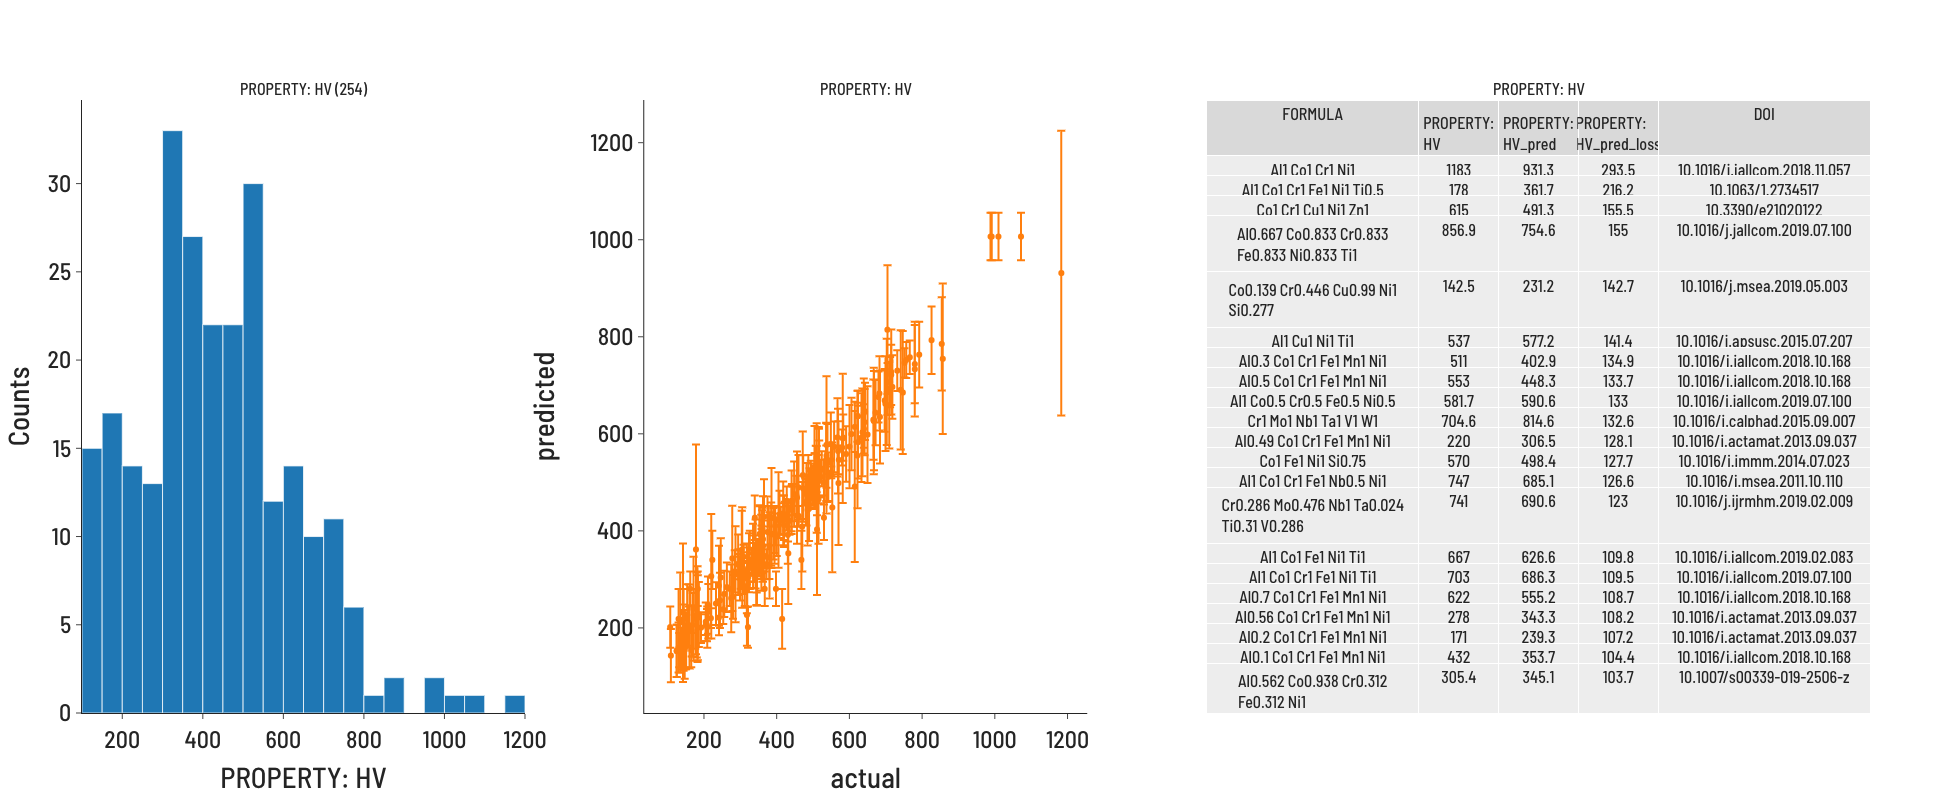

16233 PROPERTY: YS (MPa)
16233
Batch length:  1118
Index(['IDENTIFIER: Reference ID', 'FORMULA', 'PROPERTY: Microstructure',
       'PROPERTY: Processing method', 'PROPERTY: BCC/FCC/other',
       'PROPERTY: grain size ($\mu$m)', 'PROPERTY: Exp. Density (g/cm$^3$)',
       'PROPERTY: Calculated Density (g/cm$^3$)', 'PROPERTY: HV',
       'PROPERTY: Type of test', 'PROPERTY: Test temperature ($^\circ$C)',
       'PROPERTY: YS (MPa)', 'PROPERTY: UTS (MPa)', 'PROPERTY: Elongation (%)',
       'PROPERTY: Elongation plastic (%)',
       'PROPERTY: Exp. Young modulus (GPa)',
       'PROPERTY: Calculated Young modulus (GPa)',
       'PROPERTY: O content (wppm)', 'PROPERTY: N content (wppm)',
       'PROPERTY: C content (wppm)', 'REFERENCE: doi', 'REFERENCE: year',
       'REFERENCE: title', 'Predicted Property YS',
       'Predicted Property YS loss'],
      dtype='object')
headers:  PROPERTY: YS (MPa) PROPERTY: YS (MPa)_pred PROPERTY: YS (MPa)_pred_loss


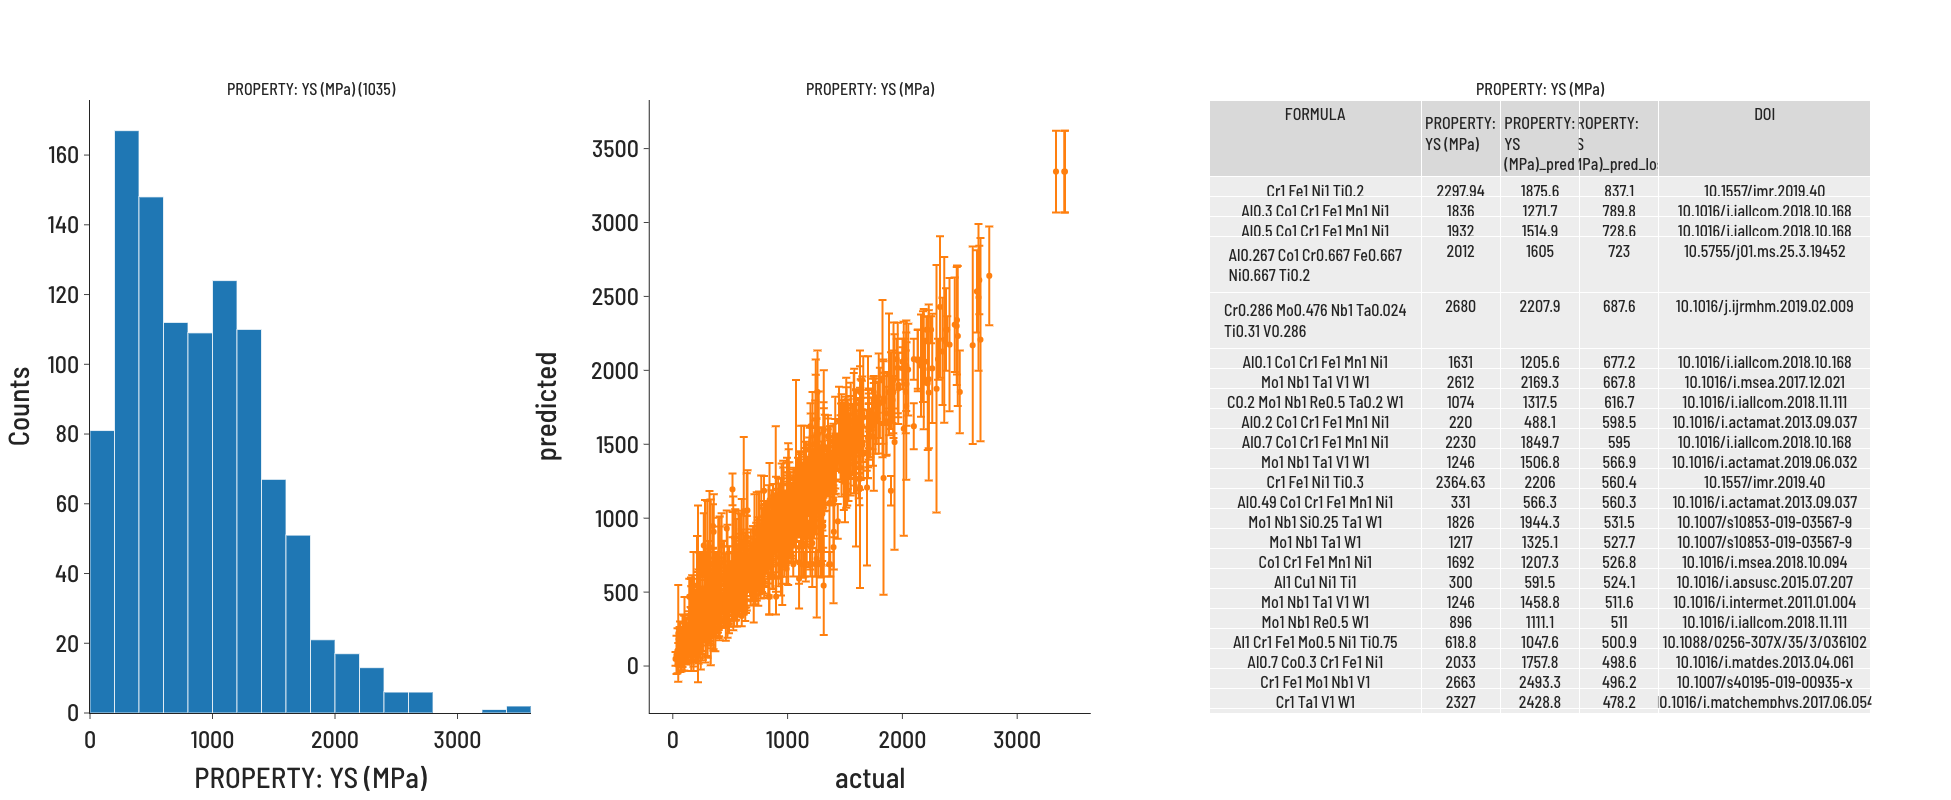

16235 PROPERTY: UTS (MPa)
16235
Batch length:  1118


AttributeError: 'NoneType' object has no attribute 'value'

In [43]:
dv_ids = [16230, 16231, 16232, 16233, 16235, 16236, 16237, 16238, 16269]


for dv_id, out in zip(dv_ids, outs):
    print(dv_id, out)
    
    input_df = pd.read_csv('../../MPEA_dataset.csv')
    features = ['FORMULA', 'PROPERTY: Processing method', 'PROPERTY: Type of test', 'PROPERTY: Test temperature ($^\circ$C)']
    df_candidates = input_df.dropna(subset=features)

    updated_key = out.split('(')[0].strip().replace('PROPERTY:', 'Property')

    if out == 'PROPERTY: UTS (MPa)':
        updated_key = 'Property Ultimate tensile strength'        

    df_candidates = predict(df_candidates, out, updated_key, dv_id)
    plot(df_candidates.dropna(subset=[out]), out, updated_key)

In [19]:
import plotly
plotly.offline.init_notebook_mode()